# Natural Language Processing with Transformers

## Chapter 7 - Question Answering

- we are doing EXTRACTIVE QA here (lists other examples like community QA, long form QA etc)

## Building a review based QA system

### Dataset - SubjQA

- customer reviews in english about products and services in 6 domains: tripadvisor, restaurants, movies etc.
- each review is associated with a question that can be answersd using one or more sentences in the review
- the Q and A are subjective ie depend on the users experience/preference etc (**so more difficult than factual QA like what is capital of UK etc**)





In [1]:
from datasets import get_dataset_config_names

domains = get_dataset_config_names("subjqa")

domains

['books', 'electronics', 'grocery', 'movies', 'restaurants', 'tripadvisor']

**we focus on just ELECTRONICS for this chapter**

In [2]:
from datasets import load_dataset

subjqa = load_dataset("subjqa", name="electronics")

In [3]:
subjqa["train"]

Dataset({
    features: ['domain', 'nn_mod', 'nn_asp', 'query_mod', 'query_asp', 'q_reviews_id', 'question_subj_level', 'ques_subj_score', 'is_ques_subjective', 'review_id', 'id', 'title', 'context', 'question', 'answers'],
    num_rows: 1295
})

In [4]:
print(subjqa["train"]["context"][1], subjqa["train"]["question"][1], subjqa["train"]["answers"][1], sep='\n\n\n')

To anyone who hasn't tried all the various types of headphones, it is important to remember exactly what these are: cheap portable on-ear headphones. They give a totally different sound then in-ears or closed design phones, but for what they are I would say they're good. I currently own six pairs of phones, from stock apple earbuds to Sennheiser HD 518s. Gave my Portapros a run on both my computer's sound card and mp3 player, using 256 kbps mp3s or better. The clarity is good and they're very lightweight. The folding design is simple but effective. The look is certainly retro and unique, although I didn't find it as comfortable as many have claimed. Earpads are *very* thin and made my ears sore after 30 minutes of listening, although this can be remedied to a point by adjusting the "comfort zone" feature (tightening the temple pads while loosening the ear pads). The cord seems to be an average thickness, but I wouldn't get too rough with these. The steel headband adjusts smoothly and e

Like other question answering datasets on the Hub, SubjQA stores the answers to
each question as a nested dictionary. For example, if we inspect one of the rows in the
answers column we can see that the answers are stored in a text field, while the starting character
indices are provided in answer_start. To explore the dataset more easily, we’ll flatten these nested columns with the flatten() method and convert each split to a Pandas
DataFrame as follows

In [5]:
import pandas as pd
dfs = {split: dset.to_pandas() for split, dset in subjqa.flatten().items()}

for split, df in dfs.items():
    print(f"Number of questions in {split}: {df['id'].nunique()}")

Number of questions in train: 1295
Number of questions in test: 358
Number of questions in validation: 255


**interesting columns:**

- title (amazon id of product)
- question
- answer text, start
- context (customer review itself)

NOTE:

- **an empty answers.text entry denotes “unanswerable” questions whose answer cannot be found in the review**


In [6]:
qa_cols = ["title", "question", "answers.text",
"answers.answer_start", "context"]
sample_df = dfs["train"][qa_cols].sample(2, random_state=7)
sample_df

,title,question,answers.text,answers.answer_start,context
791,B005DKZTMG,Does the keyboard lightweight?,[this keyboard is compact],[215],I really like this keyboard. I give it 4 star...
1159,B00AAIPT76,How is the battery?,[],[],I bought this after the first spare gopro batt...


### EDA ideas cont.

Next, let’s get a feel for what types of questions are in the training set by counting the
questions that begin with a few common starting words:

In [7]:
from matplotlib import pyplot as plt

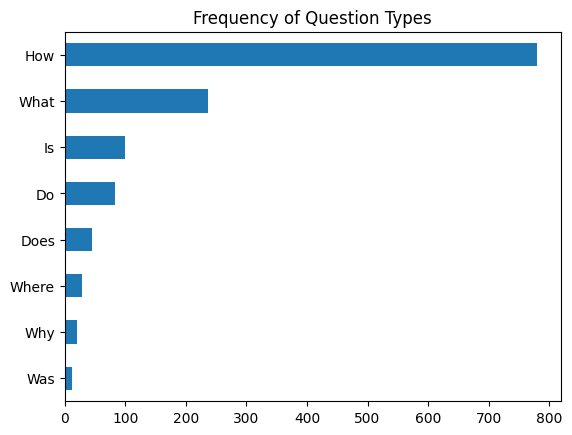

In [8]:
counts = {}
question_types = ["What", "How", "Is", "Does", "Do", "Was", "Where", "Why"]

for q in question_types:
    counts[q] = dfs["train"]["question"].str.startswith(q).value_counts()[True]

pd.Series(counts).sort_values().plot.barh()

plt.title("Frequency of Question Types")
plt.show()

**comment about SubjQA:** 

- says that the format (question, review, answer_sentences) was pioneered by SQaAD dataset
- SQuAD 2.0 has adverserial examples (questions that are relevant to a given passage but cant be answered from text alone)

SOTA on Squad 2 surpasses human performance but:

However, this superhuman performance does not appear to reflect genuine reading
comprehension, since answers to the “unanswerable” questions can usually be identified through patterns in the passages like antonyms. To address these problems Goo‐
gle released the Natural Questions (NQ) dataset,7 which involves fact-seeking
questions obtained from Google Search users. The answers in NQ are much longer
than in SQuAD and present a more challenging benchmark.

---

## How do transformers extract answers from text?

The first thing we’ll need for our QA system is to find a way to identify a potential
answer as a span of text in a customer review. For example, if a we have a question
like “Is it waterproof?” and the review passage is “This watch is waterproof at 30m
depth”, then the model should output “waterproof at 30m”. To do this we’ll need to
understand how to:

1. Frame the supervised learning problem.
2. Tokenize and encode text for QA tasks.
3. Deal with long passages that exceed a model’s maximum context size

---

## 1 - Framing as SPAN CLASSIFICATION task

- the start and the end token of an answer span will act as the labels that the model needs to predict (see p173 of book for illustration)

**NOTE: TODO: confirm this is correct - from the picture it seems that you send `CLS question SEP full text` ie the question and text-to-search are one big sequence, with a separator**

We start with a LM that has already been finetuned on large scale QA

(NOTE THAT unlike previous cases, where we had to finetune as e.g. number of classes we wanted was different, here the structure of the "labels" remaisn the same across QA datasets (start and end position))

Good models (book 2020) are: 

- miniLM
- roberta-base
- albert-xxl

We use miniLM for this examples (fast to train)

### tokenizing text for QA task

In [9]:
from transformers import AutoTokenizer

model_ckpt = "deepset/minilm-uncased-squad2"

tokenizer = AutoTokenizer.from_pretrained(model_ckpt)

To see the model in action, let’s first try to extract an answer from a short passage of
text. In extractive QA tasks, the inputs are provided as (question, context) pairs, so we
pass them both to the tokenizer as follows:

**REMEMBER: tokenizer can accept lists of sentences etc**

In [10]:
question = "How much music can this hold?"
context = """An MP3 is about 1 MB/minute, so about 6000 hours depending on \
file size."""
inputs = tokenizer(question, context, return_tensors="pt")


In [11]:
inputs

{'input_ids': tensor([[  101,  2129,  2172,  2189,  2064,  2023,  2907,  1029,   102,  2019,
         23378,  2003,  2055,  1015, 16914,  1013,  3371,  1010,  2061,  2055,
         25961,  2847,  5834,  2006,  5371,  2946,  1012,   102]]), 'token_type_ids': tensor([[0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
         1, 1, 1, 1]]), 'attention_mask': tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
         1, 1, 1, 1]])}

we can see the familiar input_ids and attention_mask tensors, while the
token_type_ids tensor indicates which part of the inputs corresponds to the question and context (a 0 indicates a question token, a 1 indicates a context token

To understand how the tokenizer formats the inputs for QA tasks, let’s decode the
input_ids tensor

In [12]:
print(tokenizer.decode(inputs["input_ids"][0]))

[CLS] how much music can this hold? [SEP] an mp3 is about 1 mb / minute, so about 6000 hours depending on file size. [SEP]


In [13]:
import torch
from transformers import AutoModelForQuestionAnswering

model = AutoModelForQuestionAnswering.from_pretrained(model_ckpt)

with torch.no_grad():
    outputs = model(**inputs)

print(outputs)

Some weights of the model checkpoint at deepset/minilm-uncased-squad2 were not used when initializing BertForQuestionAnswering: ['bert.pooler.dense.bias', 'bert.pooler.dense.weight']
- This IS expected if you are initializing BertForQuestionAnswering from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForQuestionAnswering from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


QuestionAnsweringModelOutput(loss=None, start_logits=tensor([[-0.9862, -4.7750, -5.4025, -5.2378, -5.2863, -5.5117, -4.9819, -6.1880,
         -0.9862,  0.2596, -0.2144, -1.7136,  3.7806,  4.8561, -1.0546, -3.9097,
         -1.7374, -4.5944, -1.4278,  3.9949,  5.0391, -0.2018, -3.0193, -4.8549,
         -2.3107, -3.5110, -3.5713, -0.9862]]), end_logits=tensor([[-0.9623, -5.4733, -5.0326, -5.1639, -5.4278, -5.5151, -5.1749, -4.6233,
         -0.9623, -3.7855, -0.8715, -3.7745, -3.0162, -1.1780,  0.1758, -2.7365,
          4.8934,  0.3046, -3.1761, -3.2762,  0.8937,  5.6606, -0.3623, -4.9554,
         -3.2531, -0.0914,  1.6211, -0.9623]]), hidden_states=None, attentions=None)


Here we can see that we get a QuestionAnsweringModelOutput object as the output of
the QA head. As illustrated in Figure 7-4 (**p173 of book**), the QA head corresponds to a linear layer
that takes the hidden states from the encoder and computes the logits for the start
and end spans. This means that we treat QA as a form of token classification, similar
to what we encountered for named entity recognition in Chapter 4. To convert the
outputs into an answer span, we first need to get the logits for the start and end
tokens:

**NOTE: TODO - check/confirm that logically the location of the start and end span is RESTRICTED TO LIE IN THE "context / text" PART AND CANNOT BE IN THE EARLIER "question" PART** would be stupid otherwise

**ALSO: that the max end logit always occurs after the start logit ??? how is this ensured???**

In [14]:
start_logits = outputs.start_logits
end_logits = outputs.end_logits

print(f"Input IDs shape: {inputs.input_ids.size()}")
print(f"Start logits shape: {start_logits.size()}")
print(f"End logits shape: {end_logits.size()}")

Input IDs shape: torch.Size([1, 28])
Start logits shape: torch.Size([1, 28])
End logits shape: torch.Size([1, 28])


In [15]:
# get the argmax over the start and end logits, then get the corresponding span for these start:end positions

start_idx = torch.argmax(start_logits)
end_idx = torch.argmax(end_logits) + 1

answer_span = inputs["input_ids"][0][start_idx:end_idx]
answer = tokenizer.decode(answer_span)

print(f"Question: {question}")
print(f"Answer: {answer}")

Question: How much music can this hold?
Answer: 6000 hours


All of these preprocessing and postprocessing
steps are conveniently wrapped in a dedicated pipeline. We can instantiate the pipeline by passing our tokenizer and fine-tuned model as follows:

**NOTE: TODO: notice there is a topk / top_k option - understand how it works - is it taking top_k over the PAIRS (start,end) ???? so an `n^2` comparison for all possible start and end offsets taking the max prob of the sum for ex??**

In [16]:
from transformers import pipeline

pipe = pipeline("question-answering", model=model, tokenizer=tokenizer)

pipe(question=question, context=context, topk=3)

2024-05-13 22:02:30.073838: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-05-13 22:02:30.073895: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-05-13 22:02:30.075317: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
/opt/conda/lib/python3.10/site-packages/transformers/pipelines/question_answering.py:326: UserWarning: topk parameter is deprecated, use top_k instead
  warnings.warn("topk parameter is deprecated, use top_k instead", UserWarning)


[{'score': 0.2651631534099579, 'start': 38, 'end': 48, 'answer': '6000 hours'},
 {'score': 0.22082939743995667,
  'start': 16,
  'end': 48,
  'answer': '1 MB/minute, so about 6000 hours'},
 {'score': 0.10253427177667618,
  'start': 16,
  'end': 27,
  'answer': '1 MB/minute'}]

**IMPORTANT: comment**

In addition to the answer, the pipeline also returns the model’s probability estimate in
the score field (obtained by taking a softmax over the logits). This is handy when we
want to compare multiple answers within a single context. We’ve also shown that we
can have the model predict multiple answers by specifying the topk parameter. Sometimes, it is possible to have questions for which no answer is possible, like the empty
answers.answer_start examples in SubjQA. In these cases the model will assign a
high start and end score to the [CLS] token, and the pipeline maps this output to an
empty string:

In [17]:
pipe(question="Why is there no data?", context=context, handle_impossible_answer=True)

{'score': 0.906841516494751, 'start': 0, 'end': 0, 'answer': ''}

### NOTE: answer to one of my earlier questions

In our simple example, we obtained the start and end indices by
taking the argmax of the corresponding logits. However, this heuristic can produce out-of-scope answers by selecting tokens that
belong to the question instead of the context. In practice, the pipeline computes the best combination of start and end indices subject
to various constraints such as being in-scope, requiring the start
indices to precede the end indices, and so on.


---

## Dealing with long passages

- for QA, the context (ie the text queried) is often much larger than the max seq length of the model (miniLM = 512 tokens for example)
- in some tasks you can just truncate (eg text classif) since the "beginning is representative" but for QA the answer might lie in the final part of the text, so can't just truncate
- one standard way is to use a sliding window: **create multiple question-context pairs for long documents**

in HF you can use `return_overflowing_tokens=True` in the tokenizer to enable the sliding window

The size of the sliding window is controlled by the `max_seq_length` argument, and the size of the stride is controlled by `doc_stride`.

In [18]:
example = dfs["train"].iloc[0][["question", "context"]]
tokenized_example = tokenizer(example["question"], example["context"],return_overflowing_tokens=True, max_length=100,stride=25)

Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.


In [19]:
for idx, window in enumerate(tokenized_example["input_ids"]):
    print(f"Window #{idx} has {len(window)} tokens")

Window #0 has 100 tokens
Window #1 has 88 tokens


In [20]:
# example to see roughly at where the overlap is between 2 windows:

for window in tokenized_example["input_ids"]:
    print(f"{tokenizer.decode(window)} \n")

[CLS] how is the bass? [SEP] i have had koss headphones in the past, pro 4aa and qz - 99. the koss portapro is portable and has great bass response. the work great with my android phone and can be " rolled up " to be carried in my motorcycle jacket or computer bag without getting crunched. they are very light and do not feel heavy or bear down on your ears even after listening to music with them on all day. the sound is [SEP] 

[CLS] how is the bass? [SEP] and do not feel heavy or bear down on your ears even after listening to music with them on all day. the sound is night and day better than any ear - bud could be and are almost as good as the pro 4aa. they are " open air " headphones so you cannot match the bass to the sealed types, but it comes close. for $ 32, you cannot go wrong. [SEP] 



# Using Haystack to build a QA pipeline

Let's look at the other components needed (we have seen how to extract answers from text) for a QA system

- in example so far, we provided the Question AND THE CONTEXT to the model
- but in reality, users will only provide Question so we need to select relevant passages to CREATE THE CONTEXT
- in this specific case for ex, we could e.g. concatenate ALL the reviews for a given product and give it to model as a single context, **but this produces huge documents/latency etc**

To handle this modern QA typically is based on the **retriever-reader** architecture:

### Retriever

Retrieve relevant documents for a given query:

- sparse vs dense: sparse use word frequencies to represent each document and query. Dense use encoders like transformers to represent documents and queries as contextualized embeddings

### Reader

Responsible for extracting an answer from the documents provided by the retriever

---

There can be other additions to this simple model - for example **reranking** to eliminate noisy results etc, postprocessing of results from several disjointed documents etc

---

To build this QA system we use **Haystack** library. We will also need to use a **document store** (database to store documents and metadata, used by the retriever for queries)

## Creating a document store

Haystack has options for document stores: Elasticsearch, Faiss, Milvus

and also for retrivers: sparse {TFIDF, BM-25}, dense {embedding, DPR}

**we will use `ElasticsearchDocumentStore`, which is compatible with both retriever types**

In [21]:
url = """https://artifacts.elastic.co/downloads/elasticsearch/\
elasticsearch-7.9.2-linux-x86_64.tar.gz"""

!wget -nc -q {url}
!tar -xzf elasticsearch-7.9.2-linux-x86_64.tar.gz

In [22]:
import os
from subprocess import Popen, PIPE, STDOUT
# Run Elasticsearch as a background process
!chown -R daemon:daemon elasticsearch-7.9.2
es_server = Popen(args=['elasticsearch-7.9.2/bin/elasticsearch'], stdout=PIPE, stderr=STDOUT, preexec_fn=lambda: os.setuid(1))
# Wait until Elasticsearch has started
!sleep 30

In [23]:
!curl -X GET "localhost:9200/?pretty"

{
  "name" : "ea58dc71893c",
  "cluster_name" : "elasticsearch",
  "cluster_uuid" : "ag9sVHn2TG6QBM4egCgkxg",
  "version" : {
    "number" : "7.9.2",
    "build_flavor" : "default",
    "build_type" : "tar",
    "build_hash" : "d34da0ea4a966c4e49417f2da2f244e3e97b4e6e",
    "build_date" : "2020-09-23T00:45:33.626720Z",
    "build_snapshot" : false,
    "lucene_version" : "8.6.2",
    "minimum_wire_compatibility_version" : "6.8.0",
    "minimum_index_compatibility_version" : "6.0.0-beta1"
  },
  "tagline" : "You Know, for Search"
}


In [24]:
#!pip install haystack

In [25]:
#!pip uninstall haystack

In [26]:
#!pip install farm-haystack

In [27]:
!pip install farm-haystack[all]

In [28]:
#from haystack.document_store.elasticsearch import ElasticsearchDocumentStore
from haystack.document_stores import ElasticsearchDocumentStore

# Return the document embedding for later use with dense retriever
document_store = ElasticsearchDocumentStore(return_embedding=True)

2024-05-13 22:03:33,150	INFO util.py:124 -- Outdated packages:
  ipywidgets==7.7.1 found, needs ipywidgets>=8
Run `pip install -U ipywidgets`, then restart the notebook server for rich notebook output.


**p185 of book:** shows expected layout for Haystack document stores, how to add metadata to each document:

In [29]:
for split, df in dfs.items():
    # Exclude duplicate reviews
    docs = [{"text": row["context"],
             "meta":{"item_id": row["title"], "question_id": row["id"],"split": split}}
            for _,row in df.drop_duplicates(subset="context").iterrows()]
    
    document_store.write_documents(docs, index="document")

print(f"Loaded {document_store.get_document_count()} documents")

TypeError: Document.__init__() missing 1 required positional argument: 'content'

# TODO: loads of errors - looked up online seems Haystack has major changes - either read their tutorials or just build using Pinecone wor